In [2]:
# %%writefile ../../src/load_and_parse.py


import os
import json

def load_and_parse_json(file_path, debug=False):
    if debug:
        print(f"Debug: Loading and parsing file: {file_path}")
    
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            data = json.load(f)
        
        trial_id = data['trial_id']
        result = 1 if data['result'] == 'made' else 0
        landing_x = data['landing_x']
        landing_y = data['landing_y']
        entry_angle = data['entry_angle']
        release_frame = data.get('release_frame', None)

        if debug:
            print(f"Debug: Trial ID: {trial_id}, Result: {result}, Release Frame: {release_frame}")
        
        return data, trial_id, result, landing_x, landing_y, entry_angle, release_frame
    except Exception as e:
        print(f"Error: Failed to load or parse JSON file: {file_path}. Exception: {e}")
        return None, None, None, None, None, None, None

def main_load_and_parse(file_path):
    data = load_and_parse_json(file_path, debug=True)
    return data

# Test the function
if __name__ == "__main__":
    test_file = "../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json"
    main_load_and_parse(test_file)


# %%writefile ../../src/dataframe_creation.py

import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle, debug=False):
    frame_data = []
    for i, frame in enumerate(data['tracking']):
        frame_time = frame['time']
        ball_pos = frame['data'].get('ball', [None, None, None])
        player_pos = frame['data']['player']

        flat_frame = {
            'trial_id': trial_id,
            'result': result,
            'landing_x': landing_x,
            'landing_y': landing_y,
            'entry_angle': entry_angle,
            'frame_time': frame_time,
            'ball_x': ball_pos[0] if ball_pos[0] is not None else np.nan,
            'ball_y': ball_pos[1] if ball_pos[1] is not None else np.nan,
            'ball_z': ball_pos[2] if ball_pos[2] is not None else np.nan,
        }

        for part, coords in player_pos.items():
            flat_frame[f'{part}_x'] = coords[0]
            flat_frame[f'{part}_y'] = coords[1]
            flat_frame[f'{part}_z'] = coords[2]

        frame_data.append(flat_frame)
    
    df = pd.DataFrame(frame_data)

    # Set the index to the sequential frame number
    df.index = np.arange(len(df))
    print(f"Debug: DataFrame index set to sequential frame numbers. Index range: {df.index.min()} to {df.index.max()}")

    if debug:
        print(f"Debug: Created DataFrame for Trial ID: {trial_id}")
        print("Debug: Unique columns in DataFrame:", df.columns)
        print("\nDebug: Data types of columns:", df.dtypes)
        print("\nDebug: Single sample row:", df.iloc[0])
        print("\nDebug: Null value counts per column:", df.isna().sum())
        print("\nDebug: Description of numeric columns:", df.describe())

    return df


def main_create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle):
    df = create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle, debug=True)
    return df


# Test the function
if __name__ == "__main__":
    # from data_loading.load_and_parse import main_load_and_parse
    data, trial_id, result, landing_x, landing_y, entry_angle, _ = main_load_and_parse("../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json")
    main_create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle)

# %%writefile ../../src/integrity_checks.py


def check_data_integrity(df, debug=False):
    null_counts = df.isna().sum()
    
    if debug:
        print("\nDebug: Data integrity check - Missing counts for all columns:")
        print(null_counts)
    
    problematic_columns = null_counts[null_counts > 0]
    
    if not problematic_columns.empty:
        print("\nWarning: The following columns have missing data:")
        for col, count in problematic_columns.items():
            print(f"Column '{col}' has {count} missing values.")
    else:
        print("\nInfo: No columns with missing data detected.")
    
    return problematic_columns

def main_check_data_integrity(df):
    check_data_integrity(df, debug=True)

# Test the function
if __name__ == "__main__":
    # from dataframe_creation import main_create_dataframe
    # from load_and_parse import main_load_and_parse
    data, trial_id, result, landing_x, landing_y, entry_angle, _ = main_load_and_parse("../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json")
    df = main_create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle)
    main_check_data_integrity(df)



Debug: Loading and parsing file: ../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json
Debug: Trial ID: T0001, Result: 0, Release Frame: None
Debug: Loading and parsing file: ../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json
Debug: Trial ID: T0001, Result: 0, Release Frame: None
Debug: DataFrame index set to sequential frame numbers. Index range: 0 to 239
Debug: Created DataFrame for Trial ID: T0001
Debug: Unique columns in DataFrame: Index(['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle',
       'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y',
       'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y',
       'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y',
       'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z',
       'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x',
       'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z',
       'R_WRIST_x', 'R_

# ball in hands validation

Update the hand_threshold in the function to 1.5 units.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def inspect_hand_ball_distances(df, num_samples=10):
    """
    Inspect the distances between the ball and hand points for a few sample frames
    and calculate summary statistics for better understanding.
    """
    sample_df = df[['frame_time', 'ball_x', 'ball_y', 'ball_z', 
                    'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 
                    'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 
                    'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 
                    'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 
                    'dist_ball_R_1STFINGER', 'dist_ball_R_5THFINGER', 
                    'dist_ball_L_1STFINGER', 'dist_ball_L_5THFINGER']]

    print("Debug: Sample distances between the ball and hand joints:")
    print(sample_df.head(num_samples))
    
    distance_columns = ['dist_ball_R_1STFINGER', 'dist_ball_R_5THFINGER', 
                        'dist_ball_L_1STFINGER', 'dist_ball_L_5THFINGER']
    
    print("\nDebug: Summary statistics for hand-to-ball distances:")
    for col in distance_columns:
        min_dist = df[col].min()
        max_dist = df[col].max()
        mean_dist = df[col].mean()
        print(f"{col} - Min: {min_dist:.3f}, Max: {max_dist:.3f}, Mean: {mean_dist:.3f}")

    in_hands_frames = df[df['ball_in_hands'] == 1]
    print(f"\nDebug: Number of frames where ball is detected in hands: {len(in_hands_frames)}")
    if not in_hands_frames.empty:
        print(f"Debug: First few 'in hands' frames:\n{in_hands_frames[['frame_time', 'ball_x', 'ball_y', 'ball_z']].head()}")

def filter_valid_frames(df):
    """
    Filter out frames where the ball's coordinates are NaN.
    """
    valid_df = df.dropna(subset=['ball_x', 'ball_y', 'ball_z'])
    print(f"Debug: Filtered DataFrame has {len(valid_df)} valid frames out of {len(df)} total frames.")
    return valid_df

def calculate_distance(x1, y1, z1, x2, y2, z2):
    """Calculate Euclidean distance between two 3D points."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

def calculate_valid_distances(df):
    """
    Calculate distances only for frames with valid (non-NaN) coordinates.
    """
    df['dist_ball_R_1STFINGER'] = calculate_distance(
        df['ball_x'], df['ball_y'], df['ball_z'],
        df['R_1STFINGER_x'], df['R_1STFINGER_y'], df['R_1STFINGER_z']
    )
    df['dist_ball_R_5THFINGER'] = calculate_distance(
        df['ball_x'], df['ball_y'], df['ball_z'],
        df['R_5THFINGER_x'], df['R_5THFINGER_y'], df['R_5THFINGER_z']
    )
    df['dist_ball_L_1STFINGER'] = calculate_distance(
        df['ball_x'], df['ball_y'], df['ball_z'],
        df['L_1STFINGER_x'], df['L_1STFINGER_y'], df['L_1STFINGER_z']
    )
    df['dist_ball_L_5THFINGER'] = calculate_distance(
        df['ball_x'], df['ball_y'], df['ball_z'],
        df['L_5THFINGER_x'], df['L_5THFINGER_y'], df['L_5THFINGER_z']
    )
    return df

def label_ball_in_hands(df, hand_threshold=1.5):
    """
    Label when the ball is in the hands based on the distance between the ball and hand joints (using fingers)
    and ensure hands are at or above shoulder level.
    """
    df = filter_valid_frames(df)
    df = calculate_valid_distances(df)
    
    df['ball_in_hands'] = (
        ((df['dist_ball_R_1STFINGER'] < hand_threshold) |
         (df['dist_ball_R_5THFINGER'] < hand_threshold) |
         (df['dist_ball_L_1STFINGER'] < hand_threshold) |
         (df['dist_ball_L_5THFINGER'] < hand_threshold)) &
        ((df['R_1STFINGER_z'] >= df['R_SHOULDER_z']) |
         (df['R_5THFINGER_z'] >= df['R_SHOULDER_z']) |
         (df['L_1STFINGER_z'] >= df['L_SHOULDER_z']) |
         (df['L_5THFINGER_z'] >= df['L_SHOULDER_z']))
    ).astype(int)
    
    print("\nDebug: Checking if hands are above shoulder level for 'ball_in_hands' labeling.")
    above_shoulder_condition = (
        (df['R_1STFINGER_z'] >= df['R_SHOULDER_z']) |
        (df['R_5THFINGER_z'] >= df['R_SHOULDER_z']) |
        (df['L_1STFINGER_z'] >= df['L_SHOULDER_z']) |
        (df['L_5THFINGER_z'] >= df['L_SHOULDER_z'])
    )
    print(f"Debug: Number of frames where hands are at or above shoulder level: {above_shoulder_condition.sum()} out of {len(df)}")
    print("Debug: Sample of 'ball_in_hands' column with shoulder check:\n", 
          df[['frame_time', 'ball_in_hands', 'R_1STFINGER_z', 'R_SHOULDER_z', 'L_1STFINGER_z', 'L_SHOULDER_z']].head(10))
    return df

def label_shooting_motion(df):
    """
    Label the shooting motion from when the ball is at or above shoulder height and in the hands until it is released.
    """
    df = label_ball_in_hands(df)
    df['shooting_motion'] = 0
    
    in_motion = False
    for i in df.index:
        if i in df.index:
            if df.at[i, 'ball_in_hands'] == 1:
                if not in_motion:
                    print(f"Debug: Starting shooting motion at frame {df.at[i, 'frame_time']}")
                    in_motion = True  # Start of shooting motion
                df.at[i, 'shooting_motion'] = 1
            elif in_motion and df.at[i, 'ball_in_hands'] == 0:
                print(f"Debug: Ending shooting motion at frame {df.at[i, 'frame_time']}")
                df.at[i, 'shooting_motion'] = 1  # Mark the end of shooting motion
                in_motion = False  # Reset for next potential motion
        else:
            print(f"Debug: Index {i} not found in DataFrame.")
    
    num_shooting_frames = df['shooting_motion'].sum()
    print(f"\nDebug: Total number of frames identified as part of the shooting motion: {num_shooting_frames}")
    print("Debug: Sample of 'shooting_motion' column:\n", 
          df[df['shooting_motion'] == 1][['frame_time', 'ball_in_hands', 'shooting_motion']].head(10))
    return df

# Run the function to label the shooting motion
try:
    df = label_shooting_motion(df)
except KeyError as e:
    print(f"Error: KeyError encountered - {e}")
    print("Debug: Ensure that all columns used in the logic are present in the DataFrame.")


Debug: Filtered DataFrame has 119 valid frames out of 119 total frames.

Debug: Checking if hands are above shoulder level for 'ball_in_hands' labeling.
Debug: Number of frames where hands are at or above shoulder level: 23 out of 119
Debug: Sample of 'ball_in_hands' column with shoulder check:
     frame_time  ball_in_hands  R_1STFINGER_z  R_SHOULDER_z  L_1STFINGER_z  \
65        2166              0          3.281         4.752          3.591   
66        2200              0          3.308         4.752          3.610   
67        2233              0          3.336         4.754          3.626   
68        2266              0          3.363         4.755          3.641   
69        2300              0          3.390         4.757          3.655   
70        2333              0          3.414         4.759          3.666   
71        2366              0          3.436         4.760          3.674   
72        2400              0          3.456         4.761          3.681   
73        

# Find release point
    * must be within shooting motion

Debug: Loading and parsing file: ../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json
Debug: Trial ID: T0001, Result: 0, Release Frame: None
Debug: DataFrame index set to sequential frame numbers. Index range: 0 to 239
Debug: Created DataFrame for Trial ID: T0001
Debug: Unique columns in DataFrame: Index(['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle',
       'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y',
       'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y',
       'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y',
       'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z',
       'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x',
       'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z',
       'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y',
       'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y',
       'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y

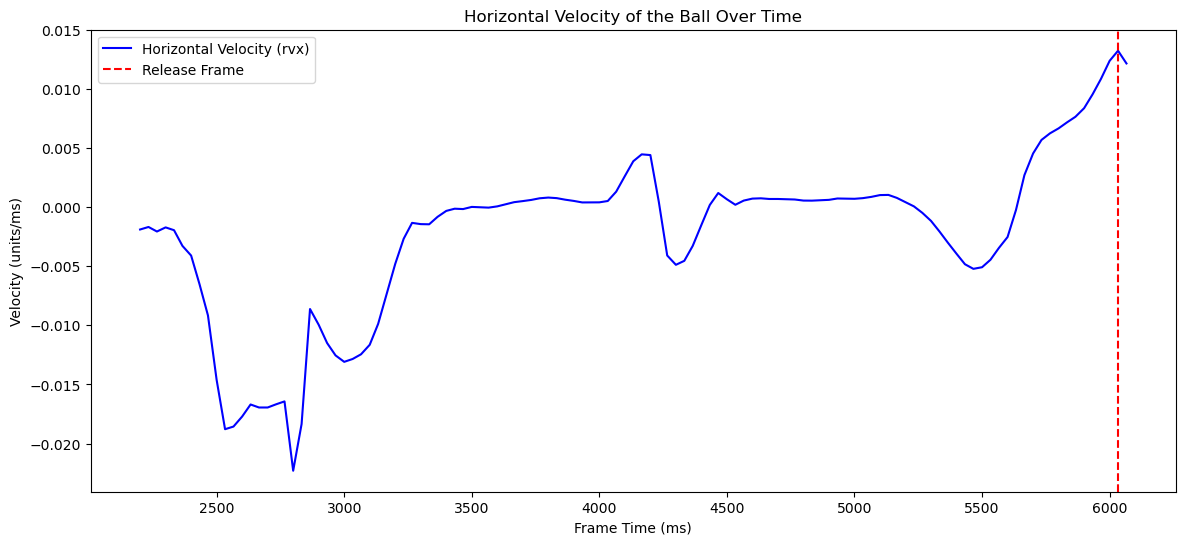

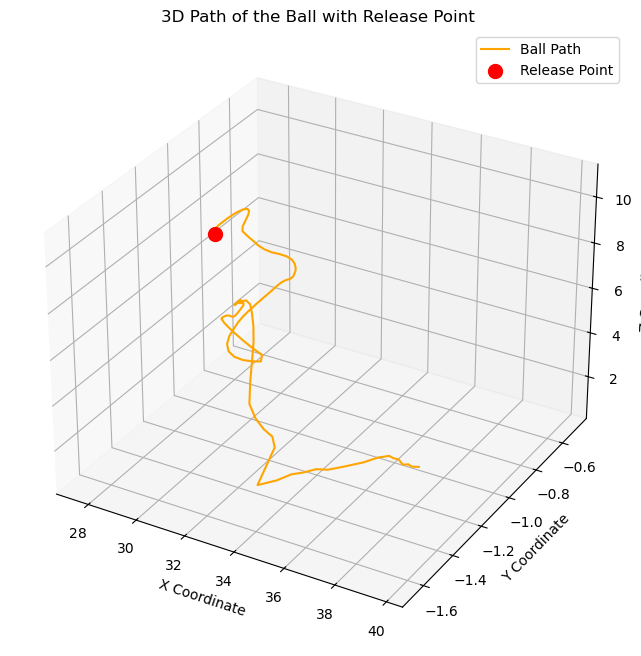

In [7]:
# %%writefile ../../src/phase_labeling.py
import numpy as np
import matplotlib.pyplot as plt

def calculate_distance(ball_coords, hand_coords):
    return np.sqrt((ball_coords[0] - hand_coords[0])**2 + (ball_coords[1] - hand_coords[1])**2 + (ball_coords[2] - hand_coords[2])**2)

def label_shot_phases(df, debug=False):
    df['phase'] = 'pre-release'
    release_frame = None
    
    # Identify the frame where horizontal velocity (rvx) towards the basket reaches its maximum
    max_horizontal_velocity_frame = df['rvx'].idxmax()
    if max_horizontal_velocity_frame is not None:
        release_frame = df.loc[max_horizontal_velocity_frame, 'frame_time']
        df.loc[df['frame_time'] >= release_frame, 'phase'] = 'post-release'
        df.loc[df['frame_time'] == release_frame, 'phase'] = 'release'
        if debug:
            print(f"Debug: Release frame detected at {release_frame} based on max horizontal velocity.")
    else:
        if debug:
            print("Warning: No release frame detected based on horizontal velocity. Check data integrity.")
    
    if debug:
        print("Phase distribution:\n", df['phase'].value_counts())
    
    return df, release_frame

def main_label_shot_phases(df):
    return label_shot_phases(df, debug=True)

def plot_velocity_and_phases(df, release_frame):
    plt.figure(figsize=(14, 6))
    plt.plot(df['frame_time'], df['rvx'], label='Horizontal Velocity (rvx)', color='blue')
    plt.axvline(x=release_frame, color='red', linestyle='--', label='Release Frame')
    plt.xlabel('Frame Time (ms)')
    plt.ylabel('Velocity (units/ms)')
    plt.title('Horizontal Velocity of the Ball Over Time')
    plt.legend()
    plt.show()

    # Plot the 3D path of the ball
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df['ball_x'], df['ball_y'], df['ball_z'], label='Ball Path', color='orange')
    ax.scatter(df.loc[df['frame_time'] == release_frame, 'ball_x'],
               df.loc[df['frame_time'] == release_frame, 'ball_y'],
               df.loc[df['frame_time'] == release_frame, 'ball_z'],
               color='red', label='Release Point', s=100)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('3D Path of the Ball with Release Point')
    ax.legend()
    plt.show()


def calculate_ball_speed_velocity_direction(df, debug=False):
    # Calculate ball speed using 3D distance and time differences
    df['ball_speed'] = (np.sqrt(
        (df['ball_x'].diff()**2) +
        (df['ball_y'].diff()**2) +
        (df['ball_z'].diff()**2)
    ) + np.sqrt(
        (df['ball_x'].shift(-1).diff()**2) +
        (df['ball_y'].shift(-1).diff()**2) +
        (df['ball_z'].shift(-1).diff()**2)
    )) / (df['frame_time'].diff() + df['frame_time'].shift(-1).diff())


    # Calculate velocity components
    df['rvx'] = (df['ball_x'].diff() / df['frame_time'].diff() +
                df['ball_x'].shift(-1).diff() / df['frame_time'].shift(-1).diff()) / 2
    df['rvy'] = (df['ball_y'].diff() / df['frame_time'].diff() +
                df['ball_y'].shift(-1).diff() / df['frame_time'].shift(-1).diff()) / 2
    df['rvz'] = (df['ball_z'].diff() / df['frame_time'].diff() +
                df['ball_z'].shift(-1).diff() / df['frame_time'].shift(-1).diff()) / 2
    df['rv'] = np.sqrt(df['rvx']**2 + df['rvy']**2 + df['rvz']**2)

    # Calculate direction components as normalized velocity
    df['direction_x'] = df['rvx'] / df['rv']
    df['direction_y'] = df['rvy'] / df['rv']
    df['direction_z'] = df['rvz'] / df['rv']

    # Fill potential NaNs from division by zero
    df[['direction_x', 'direction_y', 'direction_z']] = df[['direction_x', 'direction_y', 'direction_z']].fillna(0)

    if debug:
        print("Debug: Calculated ball speed, velocity, and direction.")
        print("Debug: NaN counts for key columns:")
        print(df[['ball_speed', 'rvx', 'rvy', 'rvz', 'rv', 'direction_x', 'direction_y', 'direction_z']].isna().sum())
        print("Sample data around release frame:\n", df[['frame_time', 'ball_speed', 'rvx', 'rvy', 'rvz', 'rv', 'direction_x', 'direction_y', 'direction_z']].head(10))
    
    return df

# Test the function with visualization
if __name__ == "__main__":
    # Assuming main_create_dataframe and main_load_and_parse are defined in your environment
    # import main_load_and_parse, main_create_dataframe
    # import calculate_ball_speed_velocity_direction
    data, trial_id, result, landing_x, landing_y, entry_angle, _ = main_load_and_parse("../../SPL-Open-Data/basketball/freethrow/data/P0001/BB_FT_P0001_T0001.json")
    df = main_create_dataframe(data, trial_id, result, landing_x, landing_y, entry_angle)
    df = calculate_ball_speed_velocity_direction(df, debug=True)
    df, release_frame = main_label_shot_phases(df)
    
    if release_frame:
        plot_velocity_and_phases(df, release_frame)
